In [1]:
import pickle
import os
import numpy as np
import shutil
import pandas as pd
import seaborn as sns
from models.gaussian_mixture import remove_outliers, gaussian_mixture
from preprocessing.read_winter import load_winter
from graphs.mixture_fit import combined_fit_mixture
import matplotlib.pyplot as plt

# 1. Create combined graphs using exoplanets data

In [77]:
def combined_gaussians(show_graph=False, save_graph=False):
    sigma = 2
    fig_dir=None
    if save_graph:  
        if os.path.isdir(f"figures/combined_gaussians"):
            shutil.rmtree(f"figures/combined_gaussians")
        fig_dir = "figures/combined_gaussians"
    
        os.mkdir(fig_dir)     
    
    labels = pd.read_csv(f"data/crossmatch/dr3/gaiaedr3_star_labels.csv", dtype={"source_id": str, "Host": str}, nrows=1172)
    
    results = []
    n_files = 0
    for file_name in os.listdir("data/densities/dr3"):
        if "_0_200000" in file_name:
            with open(f"data/densities/dr3/{file_name}", "rb") as f:
                densities = pickle.load(f)
        else:
            continue
        
        densities = densities[:1047]

        stars = []
        for i in densities:
            # Compute log10 of the host density and expand dimensions for further use
            target = np.expand_dims(np.log10(i[1]), axis=0).T

            # Remove outliers outside sigma
            data = remove_outliers(i[4], sigma=sigma)

            # Apply gaussian mixture model to the data
            model, scores = gaussian_mixture(data, [target], components=2, scores_only=False)
            
            host_name = a[a["source_id"] == i[0]].values[0][1]
            
            # Draw best fit mixture
            if "5d" in file_name:
                host = ["_".join(file_name.rsplit("_", 5)[1:4]) + "_" + host_name, target]
            else:
                host = [file_name.rsplit("_", 4)[2] + "_" + host_name, target]

            stars.append((model, data, host))
        n_files += 1
        results.append(stars)

    for i in range(len(results[0])):
        models = []
        data = []
        hosts = []
        for j in range(n_files):
            models.append(results[j][i][0])
            data.append(results[j][i][1])
            hosts.append(results[j][i][2])
        
        print(hosts)
        combined_fit_mixture(models, data, hosts, n_files, fig_dir=fig_dir, show_graph=show_graph, save_graph=save_graph)

In [ ]:
combined_gaussians(show_graph=False, save_graph=False)

# 2. Create Mass x Semi-Major axis graphs for exoplanets

In [114]:
def mass_sma(exoplanets_file, features_file):
    exoplanets_dir = "data/initial_datasets"
    class_dir = "data/classification/dr3"
    ex = pd.read_csv(os.path.join(exoplanets_dir, exoplanets_file), skiprows=28)
    df = pd.read_csv(os.path.join(class_dir, features_file), index_col=0)
    df["Host"] = df["Host"].astype(str)
    #winter = load_winter()

    ex["Host"] = ex["gaia_id"].str.replace("Gaia DR2 ", "")

    ex = ex[(ex["st_age"] > 1) & (ex["st_age"] < 4.5)]
    df = pd.merge(df, ex, on="Host")

    df = df[["Host", "gm_p_high", "pl_bmasse", "pl_orbsmax"]]
    df["pl_orbsmax"] = np.log10(df["pl_orbsmax"])  
    df["mass"] = np.log10(df["pl_bmasse"])
    
    high = df[df["gm_p_high"] > 0.84]
    low = df[df["gm_p_high"] < 0.16]
    
    fig, ax = plt.subplots(ncols=2, figsize=(10,5))
    sns.kdeplot(x=low["pl_orbsmax"], y=low["mass"], ax=ax[0], cmap="Blues", shade=True)
    sns.scatterplot(x=low["pl_orbsmax"], y=low["mass"], ax=ax[0], color="b")
    ax[0].set_xlim(-2,1)
    ax[0].set_ylim(-1, 3.5)
    ax[0].set_xticks([-2, -1, 0, 1])
    ax[0].set_yticks([-1, 0, 1, 2, 3, 3.5])
    
    sns.kdeplot(x=high["pl_orbsmax"], y=high["mass"], ax=ax[1], cmap="Reds", shade=True)
    sns.scatterplot(x=high["pl_orbsmax"], y=high["mass"], ax=ax[1], color="r")
    ax[1].set_xlim(-2,1)
    ax[1].set_ylim(-1, 3.5)
    ax[1].set_xticks([-2, -1, 0, 1])
    ax[1].set_yticks([-1, 0, 1, 2, 3, 3.5])

    return low

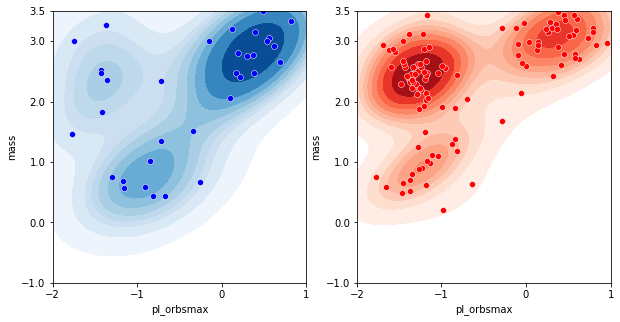

In [115]:
df = mass_sma("exoplanets.csv", "features_densities_gaiaedr3_5d_drop_rv_0_200000.csv")

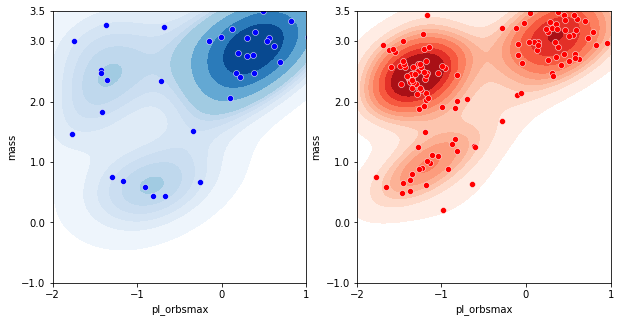

In [116]:
df = mass_sma("exoplanets.csv", "features_densities_gaiaedr3_6d_0_200000.csv")